# CSC 215 (Spring 2019): PROJECT 1


---



**Team Members: John Cyrus Kandikatla, Megha Mathpal**

We use business star ratings and reviews as target and features to pass into the below models


---



*   Linear Regression
*   Logistic Regression
*   Nearest Neighbor
*   Support Vector Machine
*   Multinomial Naive Bayes


Drive Mount

In [0]:
from google.colab import drive                     #Mounting google drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# **Imports**

In [0]:
import json
import csv
import pandas as pd
import numpy as np 
import os
from scipy.stats import zscore               # min max scaler


from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


# **Review json to csv file**

In [0]:

outfile = open("./review.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'text'])
with open('./gdrive/My Drive/review.json', encoding = "utf-8") as f:    
  for line in f:        
    row = json.loads(line)        
    # some special char must be encoded in 'utf-8'         
    sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])
outfile.close()
df_review= pd.read_csv('review.tsv', delimiter ="\t", encoding="utf-8")

In [3]:
df_review.shape

(6685900, 3)

In [4]:
df_review.head()

,business_id,stars,text
0,ujmEBvifdJM6h6RLv4wQIg,1.0,b'Total bill for this horrible service? Over $...
1,NZnhc2sEQy3RmzKTZnqtwQ,5.0,"b""I *adore* Travis at the Hard Rock's new Kell..."
2,WTqjgwHlXbSFevF32_DJVw,5.0,"b""I have to say that this office really has it..."
3,ikCg8xy5JIg_NGPx-MSIDA,5.0,"b""Went in for a lunch. Steak sandwich was deli..."
4,b1b1eb3uo-w561D0ZfCEiQ,1.0,b'Today was my second out of three sessions I ...


# **Business json to csv file**

In [0]:

outfile = open("./business.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','name','stars', 'review_count'])
with open('./gdrive/My Drive/business.json', encoding = "utf-8") as f:    
  for line in f:        
    row = json.loads(line)        
    # some special char must be encoded in 'utf-8'         
    sfile.writerow([row['business_id'] ,row['name'] ,row['stars'] ,row['review_count']])
outfile.close()
df_business= pd.read_csv('business.tsv', delimiter ="\t", encoding="utf-8")

In [6]:
df_business.shape

(192609, 4)

In [7]:
df_business.head()

,business_id,name,stars,review_count
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,3.0,5
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,2.5,128
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,4.0,170
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,5.0,3
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,4.0,4


# **Grouping ALL the reviews by each business and creating a new  dataframe,**

In [0]:
df_review_agg = df_review.groupby('business_id')['text'].sum() # Grouping reviews by business_id

In [0]:
df_ready_for_sklearn = pd.DataFrame({'business_id': df_review_agg.index, 'all_reviews': df_review_agg.values})     # group ALL the reviews by each business and create a new  dataframe,  

# **Merge two dataframes along the business_id value**

In [0]:
df_mix = pd.merge(df_ready_for_sklearn, df_business, on='business_id') # Ex:pd.merge(df_new, df_n, on='subject_id')

In [118]:
df_mix.shape

(7083, 6)

In [119]:
df_ready_for_sklearn.shape

(192606, 2)

In [13]:
df_mix.head()

,all_reviews,business_id,name,stars,review_count
0,b'If you are looking for authentic Mexican str...,--1UhMGODdWsrMastO9DZw,The Spicy Amigos,4.0,24
1,"b""They have the best Chinese BBQ Pork (Char Si...",--6MefnULPED_I942VcFNA,John's Chinese BBQ Restaurant,3.0,44
2,"b""I'm a tad reluctant to write a review as I r...",--7zmmkVg-IMGaXbuVd0SQ,Primal Brewery,4.0,58
3,b'Dr. LaCognata is great. He is a great liste...,--8LPVSo5i0Oo61X01sV9A,Valley Bone and Joint Specialists,3.5,4
4,b'Always great customer service. Affordable ha...,--9QQLMTbFzLJ_oT-ON3Xw,Great Clips,3.5,12


**Removing missing values from merged dataframe**

In [0]:
df_review = df_review.dropna()
df_business = df_business.dropna()


In [15]:
df_review.shape

(6685900, 3)

In [16]:
df_business.shape

(192609, 4)

# **Using businesses which have more than 166 reviews (2% of max review_count)**

In [0]:
df_mix = df_mix[df_mix.review_count >= 166]        # we get around 7000 businesses to work with

In [18]:
df_mix.shape

(7083, 5)

In [0]:
df_mix['all_reviews'] = df_mix['all_reviews'].str.replace('\d+', '') # removing numbers from df_mix

In [21]:
df_mix.shape

(7083, 5)

# **Normalizing review_count**

In [22]:
from sklearn.preprocessing import MinMaxScaler             # scikit min max scaler

data = df_mix.as_matrix(columns=['review_count'])
scaler = MinMaxScaler()
print(scaler.fit(data))
MinMaxScaler(copy=True, feature_range=(0, 1))
print(scaler.data_max_)
print(scaler.transform(data))
norm_data = scaler.transform(data)
df_mix['norm_review_count'] = norm_data

MinMaxScaler(copy=True, feature_range=(0, 1))
[8348.]
[[0.17685163]
 [0.02199951]
 [0.06563187]
 ...
 [0.0507211 ]
 [0.00794427]
 [0.00366659]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [23]:
df_mix.shape     #new column added

(7083, 6)

In [24]:
df_mix.head()      # Only businesses with more than 166 reviews are here hence index starting from 5

,all_reviews,business_id,name,stars,review_count,norm_review_count
5,b'Very busy and noisy restaurant.\nAsparagas w...,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,4.0,1613,0.176852
28,b'Food was good. Got the # lunch combo. At fir...,--cZ6Hhc9F7VkKXxHMVZSQ,Pio Pio,4.0,346,0.022000
53,b'The good thing about going here alone ...its...,-050d_XIor1NpCuWkbIVaQ,Matt's Big Breakfast,4.0,703,0.065632
99,b'Do not stay here unless you are willing to N...,-0qht1roIqleKiQkBLDkbw,Cancun Resort Las Vegas by Diamond Resorts,3.0,392,0.027622
122,"b""Service sucks sooooooo bad. I waited minute...",-1UMR00eXtwaeh59pEiDjA,Matt's Big Breakfast,3.5,412,0.030066


# **Vectorizing all_reviews**

In [0]:
# TfIdfVectorizer: transforms text into a "sparse matrix" where rows are text and columns are words, and values are the tf-dif values.

import sklearn.feature_extraction.text as sk_text

vectorizer = sk_text.TfidfVectorizer( stop_words='english',      # stop words = him, a, and , the, an etc
                                     max_features = 1000, lowercase=True, 
                                     min_df=1)


#max_features:  build a vocabulary that only consider the top max_features features ordered by term frequency across the corpus.
df_reviews = df_mix.all_reviews
matrix = vectorizer.fit_transform(df_reviews)



In [27]:
print(vectorizer.get_feature_names())

['able', 'absolutely', 'accommodating', 'actually', 'add', 'added', 'addition', 'afternoon', 'ago', 'ahead', 'air', 'airport', 'amazing', 'ambiance', 'ambience', 'american', 'apparently', 'appetizer', 'appetizers', 'apple', 'appreciate', 'area', 'aren', 'arrived', 'asian', 'ask', 'asked', 'asking', 'ate', 'atmosphere', 'attention', 'attentive', 'attitude', 'authentic', 'available', 'average', 'avocado', 'avoid', 'away', 'awesome', 'awful', 'ayce', 'bacon', 'bad', 'baked', 'banana', 'bar', 'barely', 'bartender', 'bartenders', 'based', 'basically', 'bathroom', 'bbq', 'bean', 'beans', 'beat', 'beautiful', 'bed', 'beef', 'beer', 'beers', 'believe', 'bellagio', 'belly', 'benedict', 'best', 'better', 'big', 'birthday', 'bit', 'bite', 'black', 'bland', 'blue', 'bomb', 'bone', 'book', 'bottle', 'bought', 'bowl', 'box', 'boy', 'boyfriend', 'bread', 'breakfast', 'bring', 'brisket', 'broth', 'brought', 'brunch', 'bucks', 'buffet', 'building', 'bun', 'bunch', 'burger', 'burgers', 'burrito', 'busin

# **Converting normalized and vectorized outputs to numpy arrays for Concatenation**

In [0]:
# Converting resultant outputs of normalization and vectorization into numpy arrays
numpyArr = matrix.toarray()
reviewCountArr = df_mix.as_matrix(columns=['norm_review_count'])

In [29]:
reviewCountArr.shape

(7083, 1)

In [30]:
numpyArr.shape

(7083, 1000)

# **Create X and Y for each model**

In [0]:
X = np.concatenate((numpyArr,reviewCountArr), axis =1)       # features used for prediction
y = np.array(df_mix.stars)                                   # target

In [32]:
from sklearn import utils

print(utils.multiclass.type_of_target(y))                     # this type is used for regression but not for classification
                                                              # Y values are linear hence no classes 



continuous


In [33]:
from sklearn import preprocessing                             # label encoding y to use in classification models

le = preprocessing.LabelEncoder()
encoded_y=le.fit_transform(y)
le.classes_

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [34]:
from sklearn import utils                                       # as we can see encoded_y is a multiclass type now

print(utils.multiclass.type_of_target(encoded_y))               # this can be used in classification models

multiclass


# **Split data to training and Testing**

In [0]:
from sklearn.model_selection import train_test_split                           # classification training and testing data

X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.2, random_state=1)  #test_size = 0.2 = test = 20%, train = 80%

In [0]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.2, random_state=1)  #Regression

# **Models**

# **Linear Regression**

In [109]:
#Linear Regression
from sklearn import  linear_model
preprocess = False
li = linear_model.LinearRegression()
li.fit(X_train_reg, y_train_reg)
li_prediction = li.predict(X_test_reg)
print('\n')
print ('Linear Regression')
print('\n')
print('Actual values:')
print('\n')
print(y_test_reg[:15])
print('\n')
print('Predicted values:')
print('\n')
print(li_prediction[:15])

def chart_regression(li_prediction,y,sort=True):
    plt.figure(figsize=(20,5))
    t = pd.DataFrame({'li_prediction' : li_prediction, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['li_prediction'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.xlim([0.0, 40.0])
    plt.ylim([0.0, 5.0])
    plt.show()
    
    



Linear Regression


Actual values:


[3.5 4.5 4.  3.5 4.  3.5 3.5 4.  3.5 3.5 4.5 3.5 2.5 4.  4.5]


Predicted values:


[3.53235771 4.36571788 4.00795038 3.56283141 3.73724097 3.82282087
 3.2184098  4.09923461 3.60150011 3.76940699 4.26151295 3.47071886
 2.62464387 4.10462066 4.51949841]


## **Chart regression for Linear regression**

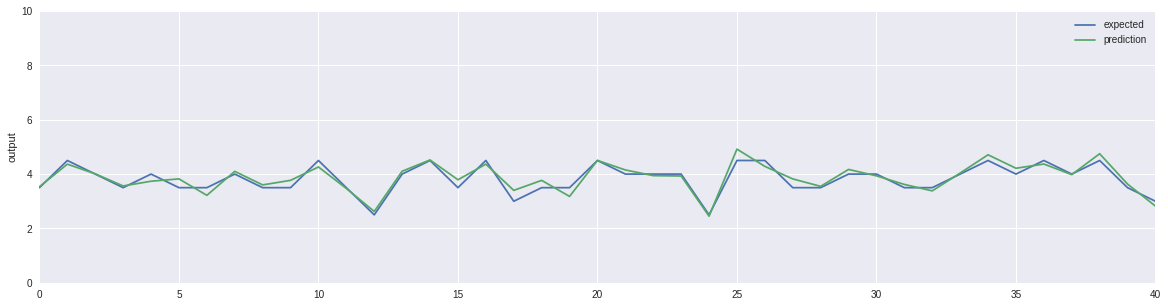

In [116]:

chart_regression(li_prediction.flatten(),y_test_reg,sort=False)


## **Regression Loss**

In [70]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# The coefficients
print('Coefficients: \n', li.coef_)

print("Mean squared error: %.2f" % mean_squared_error(y_test, prediction_lr))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, prediction_lr))

Coefficients: 
 [ 2.01000118 -0.41005373  0.4886997  ... -0.30931306 -0.25096418
  0.18137061]
Mean squared error: 0.55
Variance score: 0.60


# **Logistic Regression**

In [124]:
#Logistic Regression                                        # 8/15 matches

clf_lr = LogisticRegression()                                 # clf short for classifier
clf_lr.fit(X_train, y_train)
prediction_lr = clf_lr.predict(X_test)
print('\n')
print ('Logistic Regression')
print('\n')
print('confusion matrix:')
print(confusion_matrix(y_test, prediction))
print('\n')
print('classification report:')
print(classification_report(y_test, prediction))
print('Actual values:')
print(y_test[:15])
print('Predicted values:')
print(prediction_lr[:15])
preprocess = False
def chart_regression(prediction_lr,y,sort=True):
    plt.figure(figsize=(20,5))
    t = pd.DataFrame({'prediction_lr' : prediction_lr, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['prediction_lr'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.xlim([0.0, 40.0])
    plt.ylim([0.0, 10.0])
    plt.show()



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)




Logistic Regression


confusion matrix:
[[  0   0   0   2   0   0   0   0   0]
 [  0   0   0   6   2   1   0   0   0]
 [  0   0   0   9   1   2   1   0   0]
 [  0   0   0  11   5  16   5   0   1]
 [  0   0   0  16  15  45  61   2   2]
 [  0   0   0   8  22  34 271  16   1]
 [  0   0   0   5  18   6 483  42   3]
 [  0   0   0   0   5   5 185  71  13]
 [  0   0   0   0   0   0   3  11  12]]


classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        13
           3       0.19      0.29      0.23        38
           4       0.22      0.11      0.14       141
           5       0.31      0.10      0.15       352
           6       0.48      0.87      0.62       557
           7       0.50      0.25      0.34       279
           8       0.38      0.46      0.41        26

   micro avg       0.44      0.44      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## **Chart regression for Logistic regression**

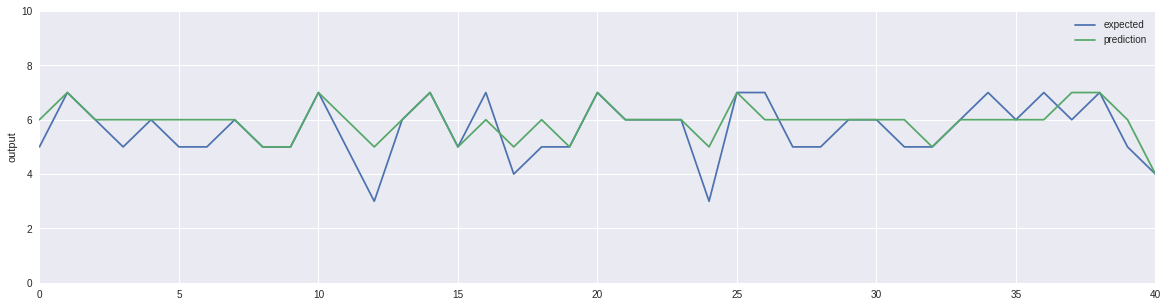

In [126]:
chart_regression(prediction_lr.flatten(),y_test,sort=False)


# **Nearest neighbour**

In [72]:
#Nearest neighbor                                                         3/15 matches

neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)
neigh_prediction = neigh.predict(X_test)
print ('Nearest Neighbor')
print('\n')
print('confusion matrix:')
print(confusion_matrix(y_test, neigh_prediction))
print('\n')
print('classification report:')
print(classification_report(y_test, neigh_prediction))
print('Actual values:')
print(y_test[:15])
print('Predicted values:')
print(neigh_prediction[:15])

Nearest Neighbor


confusion matrix:
[[  0   2   0   0   0   0   0   0   0]
 [  0   5   2   2   0   0   0   0   0]
 [  0   4   3   4   1   0   1   0   0]
 [  0   0   6  17   9   3   3   0   0]
 [  0   3   1  21  49  48  17   2   0]
 [  0   0   2   9  41 158 132  10   0]
 [  0   1   1   3  12 144 344  52   0]
 [  0   0   0   0   2  26 151  96   4]
 [  0   0   0   0   0   0   5  13   8]]


classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      0.56      0.42         9
           2       0.20      0.23      0.21        13
           3       0.30      0.45      0.36        38
           4       0.43      0.35      0.38       141
           5       0.42      0.45      0.43       352
           6       0.53      0.62      0.57       557
           7       0.55      0.34      0.42       279
           8       0.67      0.31      0.42        26

   micro avg       0.48      0.48      0.48 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# **SVM Support Vector Machine**

In [71]:
#SVM                                                                     10/15 matches
from sklearn.svm import SVC

svm_clf = SVC(kernel='linear')
svm_clf.fit(X_train, y_train)
svm_prediction = svm_clf.predict(X_test)
print('\n')
print ('SVM')
print('\n')
print('confusion matrix:')
print(confusion_matrix(y_test, svm_prediction))
print('\n')
print('classification report:')
print(classification_report(y_test, svm_prediction))
print('Actual values:')
print(y_test[:15])
print('Predicted values:')
print(svm_prediction[:15])



SVM


confusion matrix:
[[  0   2   0   0   0   0   0   0   0]
 [  0   5   1   3   0   0   0   0   0]
 [  0   2   1   5   5   0   0   0   0]
 [  0   0   0   7  31   0   0   0   0]
 [  0   2   0   2  73  63   1   0   0]
 [  0   0   0   0  17 237  97   1   0]
 [  0   0   0   0   2  34 483  38   0]
 [  0   0   0   0   0   0  83 195   1]
 [  0   0   0   0   0   0   0  22   4]]


classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.45      0.56      0.50         9
           2       0.50      0.08      0.13        13
           3       0.41      0.18      0.25        38
           4       0.57      0.52      0.54       141
           5       0.71      0.67      0.69       352
           6       0.73      0.87      0.79       557
           7       0.76      0.70      0.73       279
           8       0.80      0.15      0.26        26

   micro avg       0.71      0.71      0.71      1417
 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Multinomial Naive Bayes model

In [66]:
# Multinomial Naive Bayes model                                # 2/15 matches

clf = MultinomialNB()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print('\n')
print ('MultinomialNB')
print('\n')
print('confusion matrix:')
print(confusion_matrix(y_test, prediction))
print('\n')
print('classification report:')
print(classification_report(y_test, prediction))
print('Actual values:')
print(y_test[:15])
print('Predicted values:')
print(prediction[:15])



MultinomialNB


confusion matrix:
[[  0   0   0   2   0   0   0   0   0]
 [  0   0   0   6   2   1   0   0   0]
 [  0   0   0   9   1   2   1   0   0]
 [  0   0   0  11   5  16   5   0   1]
 [  0   0   0  16  15  45  61   2   2]
 [  0   0   0   8  22  34 271  16   1]
 [  0   0   0   5  18   6 483  42   3]
 [  0   0   0   0   5   5 185  71  13]
 [  0   0   0   0   0   0   3  11  12]]


classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        13
           3       0.19      0.29      0.23        38
           4       0.22      0.11      0.14       141
           5       0.31      0.10      0.15       352
           6       0.48      0.87      0.62       557
           7       0.50      0.25      0.34       279
           8       0.38      0.46      0.41        26

   micro avg       0.44      0.44      0.44  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
